# Building common suitablity layers for GRIDCERF


The following code was used to build the common suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Setup environment

### 1.1 Download GRIDCERF


Download the GRIDCERF package if you have not yet done so from here: https://doi.org/10.5281/zenodo.6601789. Please extract GRIDCERF inside the data directory of this repository as the paths in this notebook are set to that expectation.

### 1.2 Import necessary Python packages

In [1]:
import os
import glob
import shutil
import tempfile

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio import features
import shapely.speedups


## 2. Configuration


In [74]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF common data directory
output_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF source data directory
source_dir = os.path.join(gridcerf_dir, "source", "common")

# GRIDCERF tmp data directory
tmp_dir = os.path.join(source_dir, "tmp_files")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")


## 3. Generate common suitability rasters

### 3.1 Functions to build suitability


In [3]:
def vector_to_raster(template_raster: str, 
                     gdf: gpd.GeoDataFrame, 
                     value_field: str, 
                     output_raster: str,
                     all_touched: bool = True):
    """Convert a vector layer to a raster in the GRIDCERF format.
    
    :param template_raster:         Full path with file name and extension to the input template 
                                    raster using the GRIDCERF format.
    :type template_raster:          str 
    
    :param gdf:                     Geodataframe for the vector data.
    :type gdf:                      gpd.GeoDataFrame
    
    :param value_field:             Field to use to burn raster value in.
    :type value_field:              str
    
    :param output_raster:           Full path with output name and extension for the output raster.
    :type output_raster:            str
    
    :param all_touched:             If True, all pixels touched by geometries will be burned in. 
                                    If false, only pixels whose center is within the polygon or that 
                                    are selected by Bresenham’s line algorithm will be burned in.
    :type all_touched:              bool
    """
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform,
                                        all_touched=all_touched)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 3.2 Set standard raster template

In [4]:
# open the template raster and extract metadata and land mask
with rasterio.open(template_raster) as template:

    metadata = template.meta.copy()

    # update raster data type
    metadata.update(dtype=np.float64)

    # extract land mask
    land_mask = template.read(1)
    land_mask = np.where(land_mask == 0, np.nan, 1)

    # get the template CRS
    template_crs = template.crs
        

### 3.3 Process common layers

#### 3.3.1 Bureau of Reclamation Surface Management

> gridcerf_bor_surface_management_agency_areas.tif

- **Title**:  Bureau of Land Management (BLM) National Surface Management Agency (SMA) Area Polygons
- **Description from Source**: The purpose of this dataset is to fulfill the public and Government’s need to know what agency is managing Federal land in a given area, and for use by BLM Staff for use in analysis and reports. This dataset is useful as a tool to determine and illustrate the boundaries of a particular Federal agency’s “managing” area and to quantify these areas in terms of geographic acreage. The Surface Management Agency (SMA) Geographic Information System (GIS) dataset depicts Federal land for the United States and classifies this land by its active Federal surface managing agency. The SMA feature class covers the continental United States, Alaska, Hawaii, Puerto Rico, Guam, American Samoa and the Virgin Islands. A Federal SMA agency refers to a Federal agency with administrative jurisdiction over the surface of Federal lands. Jurisdiction over the land is defined when the land is either: Withdrawn by some administrative or legislative action, or Acquired or Exchanged by a Federal Agency. This layer is a dynamic assembly of spatial data layers maintained at various federal and local government offices. The GIS data contained in this dataset represents the polygon features that show the boundaries for Surface Management Agency and the surface extent of each Federal agency’s surface administrative jurisdiction. SMA data depicts current withdrawn areas for a particular agency and (when appropriate) includes land that was acquired or exchanged and is located outside of a withdrawal area for that agency. The SMA data do not illustrate land status ownership pattern boundaries or contain land ownership attribute details. The SMA Withdrawals feature class covers the continental United States, Alaska, Hawaii, Puerto Rico, Guam, American Samoa and the Virgin Islands. A Federal SMA Withdrawal is defined by formal actions that set aside, withhold, or reserve Federal land by statute or administrative order for public purposes. A withdrawal creates a title encumbrance on the land. Withdrawals must accomplish one or more of the following: A. Transfer total or partial jurisdiction of Federal land between Federal agencies. B. Close (segregate) Federal land to operation of all or some of the public land laws and/or mineral laws. C. Dedicate Federal land to a specific public purpose. There are four major categories of formal withdrawals: (1) Administrative, (2) Presidential Proclamations, (3) Congressional, and (4) Federal Power Act (FPA) or Federal Energy Regulatory Commission (FERC) Withdrawals. These SMA Withdrawals will include the present total extent of withdrawn areas rather than all of the individual withdrawal actions that created them over time. A Federal SMA agency refers to a Federal agency with administrative jurisdiction over the surface of Federal lands. Jurisdiction over the land is defined when the land is either: Withdrawn by some administrative or legislative action, or Acquired or Exchanged by a Federal Agency. This layer is a dynamic assembly of spatial data layers maintained at various federal and local government offices. The GIS data contained in this dataset represents the polygon features that show the boundaries for Surface Management Agency and the surface extent of each Federal agency’s surface administrative jurisdiction. SMA data depicts current withdrawn areas for a particular agency and (when appropriate) includes land that was acquired or exchanged and is located outside of a withdrawal area for that agency. The SMA data do not illustrate land status ownership pattern boundaries or contain land ownership attribute details.
- **Source URL**:  https://gbp-blm-egis.hub.arcgis.com/datasets/blm-national-sma-surface-management-agency-area-polygons/about
- **Date Accessed**:  7/27/2023
- **Citation**: 
> Bureau of Land Management. BLM National Surface Management Agency Area Polygons - National Geospatial Data Asset (NGDA). Landscape Approach Data Portal https://gbp-blm-egis.hub.arcgis.com/datasets/blm-national-sma-surface-management-agency-area-polygons/about (2023).
- **Application**: Individual rasters are created for the following layers in the geodatabase: 'STATE', 'LOCAL', 'BLM', 'BOR'. Management areas for other agencies are separately compiled.

In [5]:
# list of surface managament layers to use
surface_mgmt_list = ['BOR']

# input data
srf_mgmt_dir = os.path.join(source_dir, 'blm_service-management-agency-areas')
input_file = os.path.join(srf_mgmt_dir, "SMA_WM.gdb")

for surface_area in surface_mgmt_list:

    # read in shapefile
    gdf_bor = gpd.read_file(input_file, layer=f'SurfaceMgtAgy_{surface_area}')
    
    # reproject to GRIDCERF 
    gdf_bor = gdf_bor.to_crs(template_crs)
    
    # assign raster value field
    gdf_bor["rval"] = 1

    lowercase_name = surface_area.lower()
    
    # output raster name
    output_raster = os.path.join(output_dir, f"gridcerf_{lowercase_name}_surface_management_agency_areas.tif")
    
    # rasterize 
    vector_to_raster(template_raster, 
                     gdf_bor, 
                     value_field="rval", 
                     output_raster=output_raster,
                     all_touched=True)


_______

#### 3.3.2. US Department of Defense Layers

> gridcerf_dod_military_installations_conus.tif

- **Title**:  Military Installations, Ranges, and Training Areas
- **Description from Source**: This dataset, released by DoD, contains geographic information for major installations, ranges, and training areas in the United States and its territories. This release integrates site information about DoD installations, training ranges, and land assets in a format which can be immediately put to work in commercial geospatial information systems. Homeland Security/Homeland Defense, law enforcement, and readiness planners will benefit from immediate access to DoD site location data during emergencies. Land use planning and renewable energy planning will also benefit from use of this data. Users are advised that the point and boundary location datasets are intended for planning purposes only, and do not represent the legal or surveyed land parcel boundaries.
- **Source URL**:  https://catalog.data.gov/dataset/military-installations-ranges-and-training-areas
- **Date Accessed**:  10/9/2023
- **Citation**: 
> US Department of Defense. Military Installations, Ranges, and Training Areas. Data.gov https://catalog.data.gov/dataset/military-installations-ranges-and-training-areas (2023).
- **Application**: A GRIRDCERF raster layer is created for combined military installations, ranges, and training areas.

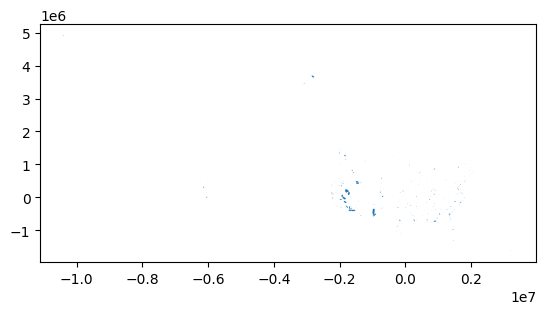

In [6]:

# input data
dod_sites_dir = os.path.join(source_dir, 'dod_military_sites')
input_file = os.path.join(dod_sites_dir, "FY21_MIRTA_V3.gdb")

gdf_mil = gpd.read_file(input_file, layer=f'MirtaLocations_A')
    
# reproject to GRIDCERF 
gdf_mil = gdf_mil.to_crs(template_crs)
    
# assign raster value field
gdf_mil["rval"] = 1

gdf_mil.plot()

    
# output raster name
output_raster = os.path.join(output_dir, f"gridcerf_dod_military_installations_conus.tif")
    
# rasterize 
vector_to_raster(template_raster, 
                     gdf_mil, 
                     value_field="rval", 
                     output_raster=output_raster,
                     all_touched=True)


_______

#### 3.3.3. Bureau of Land Management Layers

##### National Monuments

> gridcerf_blm_nlcs_national_monument_conus.tif

- **Title**:  BLM Natl NLCS National Monuments National Conservation Areas Polygons
- **Description from Source**: This feature class includes Cooperative Management and Protection Areas, Forest Reserves, National Conservation Areas, National Monuments, and Outstanding Natural Areas. Descriptions of each type of polygon found in this feature class can be found on Page 21 of the National Landscape Conservation System (NLCS) Implementation Guidelines (Version 1.1). The Bureau of Land Management's National Conservation Lands include 19 national monuments in nine western states. These national monuments encompass landscapes of tremendous beauty and diversity, ranging from rugged California coastline to vividly-hued desert canyons. The Antiquities Act of 1906 grants the President authority to designate national monuments in order to protect “objects of historic or scientific interest.” National conservation areas (NCAs) and similarly designated lands are designated by Congress to conserve, protect, enhance, and manage public lands for the benefit and enjoyment of present and future generations. The Bureau of Land Management's National Conservation Lands include 16 NCAs and five similarly designated lands in ten states. These lands feature exceptional scientific, cultural, ecological, historical, and recreational values. They differ tremendously in landscape and size, varying from the coastal beauty of California's 18-acre Piedras Blancas Light Station Outstanding Natural Area to the rugged desert vistas of Nevada's 1.2 million acre Black Rock Desert-High Rock Canyon Emigrant Trails NCA.  This polygon feature class represents the spatial extent and boundaries of the BLM National Landscape Conservation System (NLCS) National Monuments, National Conservation Areas and Similar Designations. This dataset is a subset of the official national dataset, containing features and attributes intended for public release and has been optimized for online map service performance. The Implementation Guide represents the official national dataset from which this dataset was derived.
- **Source URL**:  https://arcg.is/1u9DvO1
- **Date Accessed**:  7/18/23
- **Citation**
> Bureau of Land Management. BLM National NLCS National Monuments, National Conservation Areas and Similar Designations Polygons. U.S.Department of Interior Bureau of Land Management Geospatial Business Plaform https://gbp-blm-egis.hub.arcgis.com/datasets/BLM-EGIS::blm-natl-nlcs-national-monuments-national-conservation-areas-polygons/about (2023).


<Axes: >

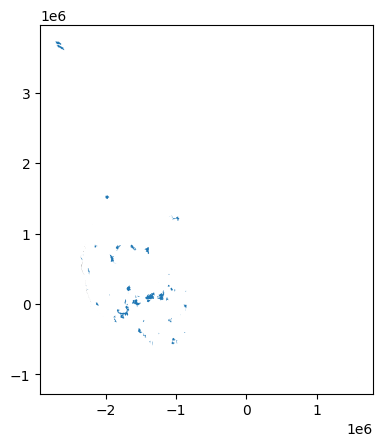

In [7]:
# source directory
data_dir = os.path.join(source_dir, "blm_nlcs_national-monuments")

# input data
input_file = os.path.join(data_dir, "BLM_Natl_NLCS_National_Monuments_National_Conservation_Areas_Polygons.shp")

# read in shapefile
gdf_nat_mon = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_nat_mon = gdf_nat_mon.to_crs(template_crs)

# assign raster value field
gdf_nat_mon["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_blm_nlcs_national_monument_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_nat_mon, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_nat_mon.plot()

_______

_______

##### BLM Wilderness Areas

> gridcerf_blm_nlcs_wilderness_conus.tif


- **Title**:  BLM Natl NLCS Wilderness Areas Polygons
- **Description from Source**:  This dataset contains the polygons that define the boundaries of the BLM National Landscape Conservation System (NLCS) Wilderness Areas and Other Related Lands. In June 2000, the BLM responded to growing concern over the loss of open space by creating the National Landscape Conservation System (NLCS). The NLCS brings into a single system some of the BLM's premier designations. The Wilderness Areas, Wilderness Study Areas, and Other Related Lands represent three of these eleven premier designations. By putting these lands into an organized system, the BLM hopes to increase public awareness of these areas' scientific, cultural, educational, ecological and other values. The data standard for these boundaries will assist in the management of all eleven designations within the NLCS. Particularly, NLCS data pertains to the following BLM groups and their purposes: Land Use Planners, GIS Specialists, NLCS team leads, BLM managers, and public stakeholder groups.  Feature Class for the BLM Wilderness Areas and BLM Other Related Lands data covered by the National Landscape Conservation System (NLCS) Data Standard. In particular, this feature class includes the polygon features representing the spatial extent and boundaries of the BLM National Landscape Conservation System (NLCS) Wilderness Areas. A Wilderness is a special place where the earth and its community of life are essentially undisturbed; they retain a primeval character, without permanent improvements and generally appear to have been affected primarily by the forces of nature. In 1964, Congress established the National Wilderness Preservation System and designated the first Wilderness Areas in passing the Wilderness Act. The uniquely American idea of wilderness has become an increasingly significant tool to ensure long-term protection of natural landscapes. Wilderness protects the habitat of numerous wildlife species and serves as a biodiversity bank for many species of plants and animals. Wilderness is also a source of clean water. The Federal Land Policy and Management Act of 1976 directed the Bureau to inventory and study its roadless areas for wilderness characteristics. To be designated as a Wilderness Study Area, an area has to have the following characteristics: Size - roadless areas of at least 5,000 acres of public lands or of a manageable size; Naturalness - generally appears to have been affected primarily by the forces of nature; Opportunities - provides outstanding opportunities for solitude or primitive and unconfined types of recreation. In addition, Wilderness Study Areas often have special qualities such as ecological, geological, educational, historical, scientific and scenic values. BLM National Landscape Conservation System (NLCS) Other Related Lands are lands not in Wilderness or Wilderness Study Areas that have been determined to have wilderness character through inventory or land use planning. These lands fall into one of two categories. The first category are lands with "wilderness value and characteristics". These are inventoried areas not in Wilderness or Wilderness Study Areas that have been determined to meet the size, naturalness, and the outstanding solitude and/or the outstanding primitive and unconfined recreation criteria. The second category are "wilderness characteristic protection areas". These are former lands with "wilderness value and characteristics" where a plan decision has been made to protect them. This dataset is a subset of the official national dataset, containing features and attributes intended for public release and has been optimized for online map service performance. The Implementation Guide represents the official national dataset from which this dataset was derived.
- **Source URL**:  https://arcg.is/a01uC
- **Date Accessed**:  7/18/23
- **Citation**
> Bureau of Land Management. BLM National NLCS Wilderness Areas Polygons. U.S.Department of Interior Bureau of Land Management Geospatial Business Plaform https://arcg.is/a01uC (2023).


<Axes: >

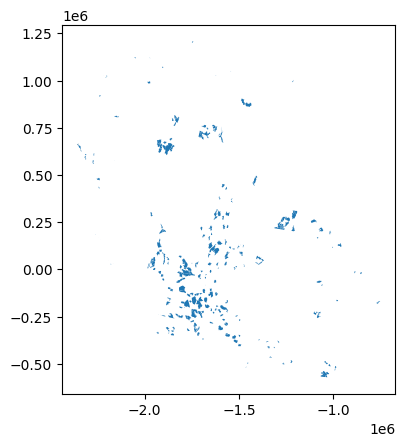

In [8]:
# source directory
data_dir = os.path.join(source_dir, "blm_nlcs_wilderness-areas")

# input data
input_file = os.path.join(data_dir, "BLM_Natl_NLCS_Wilderness_Areas_Polygons.shp")

# read in shapefile
gdf_blm_wild = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_blm_wild = gdf_blm_wild.to_crs(template_crs)

# assign raster value field
gdf_blm_wild["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_blm_nlcs_wilderness_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_blm_wild, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_blm_wild.plot()

_______

##### Wilderness Study Areas

> gridcerf_blm_nlcs_wilderness_study_areas_conus.tif


- **Title**:  BLM Natl NLCS Wilderness Study Areas Polygons
- **Description from Source**: This dataset contains the polygons that define the boundaries of the BLM National Landscape Conservation System (NLCS) Wilderness Areas and Other Related Lands. In June 2000, the BLM responded to growing concern over the loss of open space by creating the National Landscape Conservation System (NLCS). The NLCS brings into a single system some of the BLM's premier designations. The Wilderness Areas, Wilderness Study Areas, and Other Related Lands represent three of these eleven premier designations. By putting these lands into an organized system, the BLM hopes to increase public awareness of these areas' scientific, cultural, educational, ecological and other values. The data standard for these boundaries will assist in the management of all eleven designations within the NLCS. Particularly, NLCS data pertains to the following BLM groups and their purposes: Land Use Planners, GIS Specialists, NLCS team leads, BLM managers, and public stakeholder groups.  Feature Class for the BLM Wilderness Areas and BLM Other Related Lands data covered by the National Landscape Conservation System (NLCS) Data Standard. In particular, this feature class includes the polygon features representing the spatial extent and boundaries of the BLM National Landscape Conservation System (NLCS) Wilderness Areas. A Wilderness is a special place where the earth and its community of life are essentially undisturbed; they retain a primeval character, without permanent improvements and generally appear to have been affected primarily by the forces of nature. In 1964, Congress established the National Wilderness Preservation System and designated the first Wilderness Areas in passing the Wilderness Act. The uniquely American idea of wilderness has become an increasingly significant tool to ensure long-term protection of natural landscapes. Wilderness protects the habitat of numerous wildlife species and serves as a biodiversity bank for many species of plants and animals. Wilderness is also a source of clean water. The Federal Land Policy and Management Act of 1976 directed the Bureau to inventory and study its roadless areas for wilderness characteristics. To be designated as a Wilderness Study Area, an area has to have the following characteristics: Size - roadless areas of at least 5,000 acres of public lands or of a manageable size; Naturalness - generally appears to have been affected primarily by the forces of nature; Opportunities - provides outstanding opportunities for solitude or primitive and unconfined types of recreation. In addition, Wilderness Study Areas often have special qualities such as ecological, geological, educational, historical, scientific and scenic values. BLM National Landscape Conservation System (NLCS) Other Related Lands are lands not in Wilderness or Wilderness Study Areas that have been determined to have wilderness character through inventory or land use planning. These lands fall into one of two categories. The first category are lands with "wilderness value and characteristics". These are inventoried areas not in Wilderness or Wilderness Study Areas that have been determined to meet the size, naturalness, and the outstanding solitude and/or the outstanding primitive and unconfined recreation criteria. The second category are "wilderness characteristic protection areas". These are former lands with "wilderness value and characteristics" where a plan decision has been made to protect them. This dataset is a subset of the official national dataset, containing features and attributes intended for public release and has been optimized for online map service performance. The Implementation Guide represents the official national dataset from which this dataset was derived.
- **Source URL**:  https://arcg.is/a01uC
- **Date Accessed**:  7/18/23
- **Citation**
> Bureau of Land Management. BLM National NLCS Wilderness Study Areas Polygons. U.S.Department of Interior https://arcg.is/14XPiC (2023).


<Axes: >

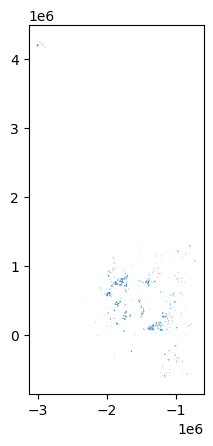

In [9]:
# source directory
data_dir = os.path.join(source_dir, "blm_nlcs_wilderness-study-areas")

# input data
input_file = os.path.join(data_dir, "BLM_Natl_NLCS_Wilderness_Study_Areas_Polygons.shp")

# read in shapefile
gdf_blm_study = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_blm_study = gdf_blm_study.to_crs(template_crs)

# assign raster value field
gdf_blm_study["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_blm_nlcs_wilderness_study_areas_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_blm_study, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_blm_study.plot()


_______

#### 3.3.4 US Environmental Protection Agency Layers

##### Class 1 Airsheds

> gridcerf_epa_class1_airsheds_conus.tif


- **Title**:  Mandatory Class 1 Federal Areas Web Service
- **Description from Source**:  This web service contains the following layers: Mandatory Class 1 Federal Area polygons and Mandatory Class 1 Federal Area labels in the United States. The polygon layer draws at all scales. The labels draw at scales greater than or equal to 1:3 million. Data used to create this web service are available as a separate download at the secondary linkage listed above. Full FGDC metadata are available by clicking the layer name in the web service table of contents and clicking the Full Metadata link in the layer description. This dataset was developed by EPA's Office of Air Quality Planning and Standards (OAQPS) based on features originating from several data sources, including USEPA, USFS, USFWS, NPS and BIA.
- **Source URL**:  https://edg.epa.gov/metadata/catalog/search/resource/details.page?uuid=%7BF234E37B-E7CE-4A47-89D6-68399D540576%7D
- **Date Accessed**:  7/18/23
- **Citation**
> United States Environmental Protection Agency. Mandatory Class 1 Federal Areas Web Service. Mandatory Class 1 Federal Areas Web Service https://edg.epa.gov/metadata/catalog/search/resource/details.page?uuid=%7BF234E37B-E7CE-4A47-89D6-68399D540576%7D (2015).


<Axes: >

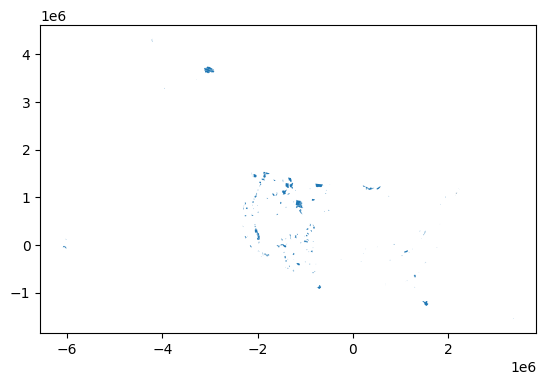

In [10]:
# source directory
data_dir = os.path.join(source_dir, "epa_class1-airsheds")

# input data
input_file = os.path.join(data_dir, "Class1_FederalAreas.gdb")

# read in shapefile
gdf_airsheds = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_airsheds = gdf_airsheds.to_crs(template_crs)

# assign raster value field
gdf_airsheds["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_epa_class1_airsheds_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_airsheds, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_airsheds.plot()

_______

#### 3.3.5 US Fish and Wildlife Service Layers

##### Critical Habitat

> gridcerf_usfws_critical_habitat_conus.tif

- **Title**:  USFWS Threatened & Endangered Species Active Critical Habitat Report
- **Description from Source**:  When a species is proposed for listing as endangered or threatened under the Endangered Species Act, the U.S. Fish and Wildlife Service must consider whether there are areas of habitat believed to be essential the species’ conservation. Those areas may be proposed for designation as “critical habitat.” Critical habitat is a term defined and used in the Act. It is a specific geographic area(s) that contains features essential for the conservation of a threatened or endangered species and that may require special management and protection. Critical habitat may include an area that is not currently occupied by the species but that will be needed for its recovery. An area is designated as “critical habitat” after the Service publishes a proposed Federal regulation in the Federal Register and receives and considers public comments on the proposal. The final boundaries of the critical habitat are also published in the Federal Register. Critical habitat are areas considered essential for the conservation of a listed species. Federal agencies are required to consult with the U.S. Fish and Wildlife Service on actions they carry out, fund, or authorize to ensure that their actions will not destroy or adversely modify critical habitat. These areas provide notice to the public and land managers of the importance of these areas to the conservation of a listed species. Special protections and/or restrictions are possible in areas where Federal funding, permits, licenses, authorizations, or actions occur or are required.
- **Source URL**:  https://ecos.fws.gov/ecp/report/table/critical-habitat.html
- **Date Accessed**:  7/18/23
- **Citation**
> U.S. Fish and Wildlife Service. USFWS Threatened & Endangered Species Active Critical Habitat Report. ECOS Environmental Conservation Online System https://ecos.fws.gov/ecp/report/table/critical-habitat.html (2023)


<Axes: >

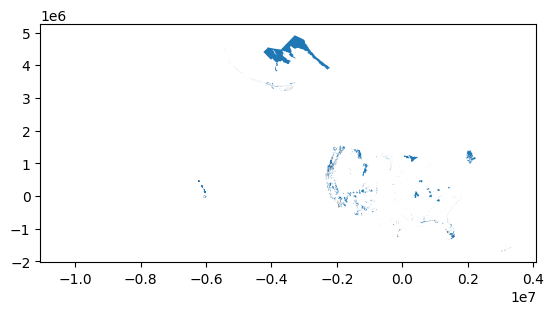

In [11]:
# source directory
data_dir = os.path.join(source_dir, "usfws_critical-habitat")

# input data
input_file = os.path.join(data_dir, "CRITHAB_POLY.shp")

# read in shapefile
gdf_crit = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_crit = gdf_crit.to_crs(template_crs)

# assign raster value field
gdf_crit["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_usfws_critical_habitat_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_crit, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)
gdf_crit.plot()


_______

##### Special Designation

> gridcerf_usfws_special_designation_conus.tif

- **Title**:  U.S. Fish and Wildlife Service (USFWS) - Special Designation
- **Description from Source**:  This data layer depicts the Special Designations that have been placed upon the lands and waters administered by the U.S. Fish and Wildlife Service (USFWS) in North America, U.S. Trust Territories and Possessions. The primary source for this information is the USFWS Realty program.  This data layer depicts the Special Designations that have been placed upon the lands and waters administered by the U.S. Fish and Wildlife Service (USFWS) in North America, U.S. Trust Territories and Possessions. These special areas, such as marine monuments, research natural areas, and natural landmarks, are primarily designated by the U.S. Congress. The primary source for this information is the USFWS Realty program.
- **Source URL**:  https://arcg.is/1jzb0H
- **Date Accessed**:  7/18/23
- **Citation**
> U.S. Fish and Wildlife. U.S. Fish and Wildlife Special Designation. U.S. Fish and Wildlife https://gis-fws.opendata.arcgis.com/datasets/fws::fws-special-designation/about (2023).


<Axes: >

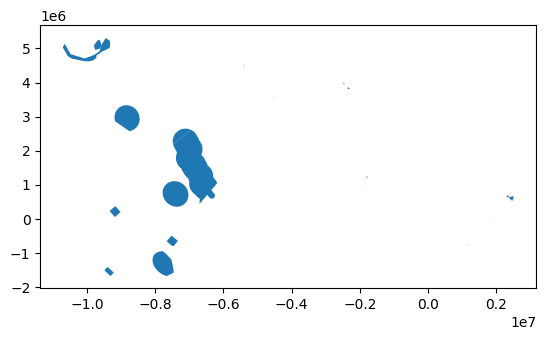

In [12]:
# source directory
data_dir = os.path.join(source_dir, "usfws_special-designation")

# input data
input_file = os.path.join(data_dir, "SpecialDesignation.shp")

# read in shapefile
gdf_spec = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_spec = gdf_spec.to_crs(template_crs)

# assign raster value field
gdf_spec["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_usfws_special_designation_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_spec, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_spec.plot()

_______

#### 3.3.6 National Land Cover Dataset Layers

##### Wetlands

> gridcerf_nlcd_wetlands_conus.tif

- **Title**:  National Land Cover Dataset (NLCD) - Wetlands
- **Description from Source**:  The U.S. Geological Survey (USGS), in partnership with several federal agencies, has developed and released five National Land Cover Database (NLCD) products over the past two decades: NLCD 1992, 2001, 2006, 2011 and 2016. These products provide spatially explicit and reliable information on the Nation’s land cover and land cover change. To continue the legacy of NLCD and further establish a long-term monitoring capability for the Nation’s land resources, the USGS designed a new generation of NLCD products released in 2016. This design continues in 2019 and aims to provide innovative, consistent, and robust methodologies for production of a multi-temporal land cover and land cover change database from 2001 to 2019 at 2–3-year intervals. Comprehensive research was conducted and resulted in processes in streamlined processes for integrating specialized MRLC partner data along with numerous newly available dataset, assembling and preprocessing Landsat imagery and geospatial ancillary datasets; a multi-source integrated training data development and machine learning based land cover classifications; a temporally, spectrally, and spatially integrated land cover change analysis strategy; a hierarchical theme-based post-classification and integration protocol for generating land cover and change products; a continuous fields biophysical parameters modeling method; and an automated operational system for the NLCD 2019 production. These processes resulted in a five percent increase in accuracy from the 2011 product for an overall Level II & I Overall accuracy (OA) 86.4% & 90.6% in the NLCD 2016 release.  (Wickham et. al, “Thematic Accuracy assessment of the NLCD 2016 land cover for the conterminous United States”, Remote Sensing of Environment, volume 257, May 2021, 112357 https://doi.org/10.1016/j.rse.2021.112357 )
- **Source URL**:  https://www.mrlc.gov/data/nlcd-2019-land-cover-conus
- **Date Accessed**:  7/18/23
- **Citation**
> Dewitz, J. & U.S. Geological Survey. National Land Cover Database (NLCD) 2019 Products (ver. 2.0, June 2021). Multi-Resoltuion Land Characteristics Consortium https://www.mrlc.gov/data/nlcd-2019-land-cover-conus (2021).


We use both wetlands categories:
- **Class 90 - Woody Wetlands**: areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.
- **Class 95 - Emergent Herbaceous Wetlands**: Areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.

**NOTE**:  Due to the large size of the NLCD raster, we conducted the following pre-processing steps in a free and open-source GIS (QGIS; https://www.qgis.org/en/site/forusers/download.html).

Here were the steps we conducted from the toolbox:
1. Used the SAGA `Resampling` tool to aggregate the NLCD 30m data to GRIDCERF 1km resolution.  We upscaled using the majority setting where the 1km gridcell would take on the majority grid cell value from the finer resoltuion data.  
2. Used the `Reclassify by table` tool to set values for wetland classes of 90 and 95 to 1 and all other classes to 0.
3. We then used the `Polygonize (raster to vector)` tool to write a polygonize the 0, 1 grid cells to a shapefile.
4. Next steps are as follows:

<Axes: >

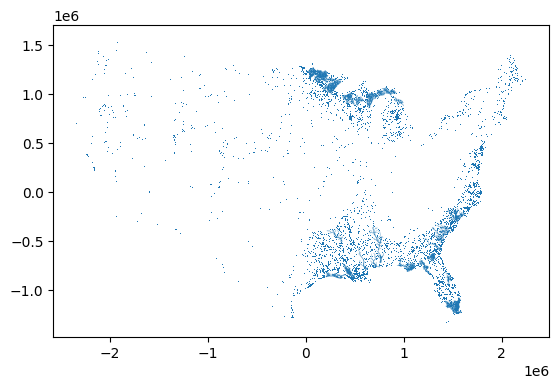

In [13]:
# source directory
data_dir = os.path.join(source_dir, "usda_nlcd_wetlands")

# input data
input_file = os.path.join(data_dir, "temp_shp_gridcerf_nlcd_wetlands_conus.shp")

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_nlcd_wetlands_conus.tif")

# read in shapefile
gdf_wetlands = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_wetlands = gdf_wetlands.to_crs(template_crs)

# reduce to wetland areas only
gdf_wetlands = gdf_wetlands[gdf_wetlands.DN.isin([90,95])]

# reset wetland value area to 1
gdf_wetlands['DN'] = 1

gdf_wetlands.plot()


In [14]:
# rasterize 
vector_to_raster(template_raster, 
                 gdf_wetlands, 
                 value_field="DN", 
                 output_raster=output_raster,
                 all_touched=True)

_______

#### 3.3.7 National Park Service Layers

##### NPS Administrative Boundaries

> gridcerf_nps_administrative_boundaries_conus.tif

- **Title**:  National Park Service tract and boundary
- **Description from Source**:  This service depicts National Park Service tract and boundary data that was created by the Land Resources Division.  NPS Director's Order #25 states: "Land status maps will be prepared to identify the ownership of the lands within the authorized boundaries of the park unit. These maps, showing ownership and acreage, are the 'official record' of the acreage of Federal and non-federal lands within the park boundaries. While these maps are the official record of the lands and acreage within the unit's authorized boundaries, they are not of survey quality and not intended to be used for survey purposes." As such this data is intended for use as a tool for GIS analysis. It is in no way intended for engineering or legal purposes. The data accuracy is checked against best available sources which may be dated and vary by location. NPS assumes no liability for use of this data. The boundary polygons represent the current legislated boundary of a given NPS unit. NPS does not necessarily have full fee ownership or hold another interest (easement, right of way, etc...) in all parcels contained within this boundary. Equivalently NPS may own or have an interest in parcels outside the legislated boundary of a given unit. In order to obtain complete information about current NPS interests both inside and outside a unit’s legislated boundary tract level polygons are also created by NPS Land Resources Division and should be used in conjunction with this boundary data. To download this data directly from the NPS go to https://irma.nps.gov/App/Portal/Home  Property ownership data is compiled from deeds, plats, surveys, and other source data. These are not engineering quality drawings and should be used for administrative purposes only. The National Park Service (NPS) shall not be held liable for improper or incorrect use of the data described and/or contained herein. These data and related graphics are not legal documents and are not intended to be used as such. The information contained in these data is dynamic and may change over time. The data are not better than the original sources from which they were derived. It is the responsibility of the data user to use the data appropriately and consistent within the limitations of geospatial data in general and these data in particular. The related graphics are intended to aid the data user in acquiring relevant data; it is not appropriate to use the related graphics as data. The National Park Service gives no warranty, expressed or implied, as to the accuracy, reliability, or completeness of these data. It is strongly recommended that these data are directly acquired from an NPS server and not indirectly through other sources which may have changed the data in some way. Although these data have been processed successfully on a computer system at the National Park Service, no warranty expressed or implied is made regarding the utility of the data on another system or for general or scientific purposes, nor shall the act of distribution constitute any such warranty. This disclaimer applies both to individual use of the data and aggregate use with other data. 
- **Source URL**:  https://public-nps.opendata.arcgis.com/datasets/nps::nps-boundary-4/about
- **Date Accessed**:  7/18/23
- **Citation**
> National Park Service. National Park Service Boundary. National Park Service https://public-nps.opendata.arcgis.com/datasets/nps::nps-boundary-4/about (2023).


<Axes: >

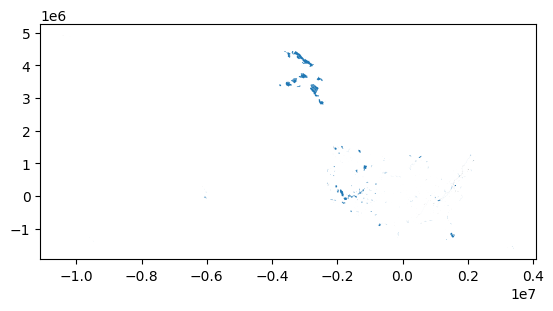

In [15]:
# source directory
data_dir = os.path.join(source_dir, "nps_boundary")

# input data
input_file = os.path.join(data_dir, "NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.shp")

# read in shapefile
gdf_nps = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_nps = gdf_nps.to_crs(template_crs)

# assign raster value field
gdf_nps["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_nps_administrative_boundaries_conus.tif")


vector_to_raster(template_raster, 
                 gdf_nps, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_nps.plot()

____

##### NPS Historic Trails

> gridcerf_nps_historic_trails_conus.tif

- **Title**:  National Historic Trails
- **Description from Source**:  National Historic Trails in the United States. The data used to create this map is a representation of the trails and in many cases an approximation and may not represent the exact location of the trails. National Historic Trails shown represent Congressionally-designated routes associated with historic trails; they are not fully developed hiking trails and may not represent physical trails. Always consult the official source for the most up-to-date information.
- **Source URL**:  https://gem.anl.gov/tool
- **Date Accessed**:  7/18/23
- **Citation**
> National Park Service. National Historic Trails. Geospatial Energy Mapper https://gem.anl.gov/tool (2019).


**NOTE**:  Trail lines are buffered by 1 km

<Axes: >

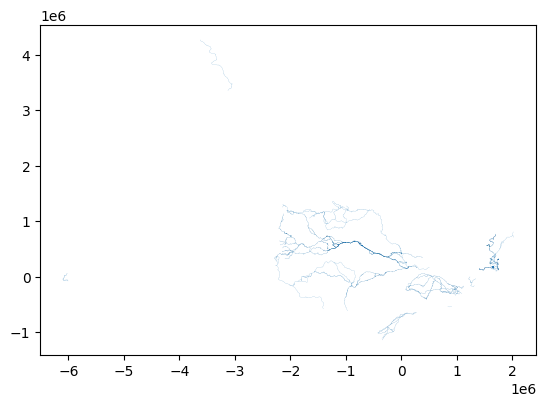

In [16]:
# source directory
data_dir = os.path.join(source_dir, "nps_historic-trails")

# input data
input_file = os.path.join(data_dir, "ez_gis.recreation_historic_trail_centerline.shp")

# read in shapefile
gdf_hist_trail = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_hist_trail = gdf_hist_trail.to_crs(template_crs)

# buffer trails by 1 km (1000 m)
gdf_hist_trail["geometry"] = gdf_hist_trail["geometry"].buffer(1000)

# assign raster value field
gdf_hist_trail["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_nps_historic_trails_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_hist_trail, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_hist_trail.plot()

____

##### NPS Scenic Trails

> gridcerf_nps_scenic_trails_conus.tif

- **Title**:  National Scenic Trails
- **Description from Source**:  National Scenic Trails in the United States. The data used to create this map is a representation of the trails and in many cases an approximation and may not represent the exact location of the trails. National Scenic Trials shown represent physical hiking trails, however many sections may still be in the design or planning stage and not yet complete. Always consult the official source for the most up-to-date information.
- **Source URL**:  https://gem.anl.gov/tool
- **Date Accessed**:  7/18/23
- **Citation**
> National Park Service. National Scenic Trails. Geospatial Energy Mapper https://gem.anl.gov/tool (2019).


**NOTE**:  Trail lines are buffered by 1 km

<Axes: >

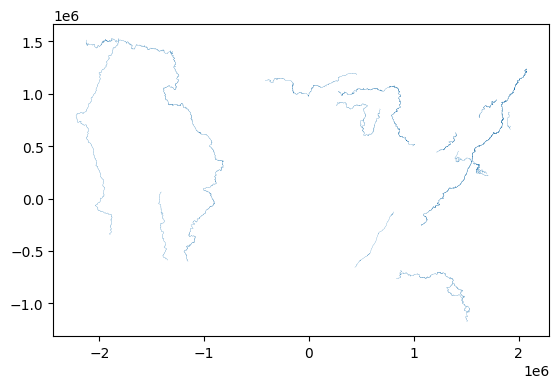

In [17]:
# source directory
data_dir = os.path.join(source_dir, "nps_scenic-trails")

# input data
input_file = os.path.join(data_dir, "ez_gis.recreation_scenic_trail_centerline.shp")

# read in shapefile
gdf_scenic_trail = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_scenic_trail = gdf_scenic_trail.to_crs(template_crs)

# buffer trails by 1 km (1000 m)
gdf_scenic_trail["geometry"] = gdf_scenic_trail["geometry"].buffer(1000)

# assign raster value field
gdf_scenic_trail["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_nps_scenic_trails_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_scenic_trail, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_scenic_trail.plot()

_______

#### 3.3.8 US Forest Service Layers

##### USFS Wild & Scenic Rivers

> gridcerf_usfs_national_wild_scenic_river_system_conus.tif

- **Title**:  National Wild and Scenic River Segments (Feature Layer)
- **Description from Source**:  This polyline feature class depicts the classification of each wild and scenic river segment designated by Congress and the Secretary of the Interior for the United States and Puerto Rico. This layer was created by a multi-agency effort including the US Forest Service, National Park Service, Bureau of Land Management and the Fish and Wildlife Service. The spatial data were referenced to the latest High Resolution National Hydrological Data Layer (NHD 1:24,000 Scale or better), published by United States Geological Survey (USGS). Wild rivers are free of dams, generally inaccessible except by trail, and represent vestiges of primitive America. Scenic rivers are free of dams, with shorelines or watersheds still largely primitive and shorelines largely undeveloped, but accessible in places by roads. Recreational rivers are readily accessible by road or railroad, may have some development along their shorelines, and may have been dammed in the past
- **Source URL**:  https://data-usfs.hub.arcgis.com/datasets/national-wild-and-scenic-river-segments-feature-layer/explore
- **Date Accessed**:  7/18/23
- **Citation**
> U.S. Forest Service, 2022. National Wild and Scenic River Segments (Feature Layer). US Forest Service - Geospatial Data Discovery., https://data-usfs.hub.arcgis.com/datasets/national-wild-and-scenic-river-segments-feature-layer/explore (accessed 10/11/23).

- **Data Notes**: Wild and Scenic rivers are actively managed by multiple US government agencies as well as jointly managed by states and those agencies. The most up to date data on this layer should be found at the National Wild Scenic River System goverment website (https://www.rivers.gov/), various file versions are available. Ensure when downloading that the file matches the most up to date Wild and Scenic River System Map (https://www.rivers.gov/sites/rivers/files/2023-07/national-map.pdf).

**NOTE**:  River centerlines are buffered by 1 km

<Axes: >

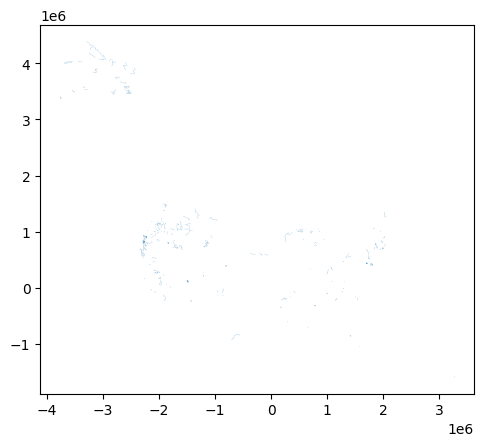

In [18]:
# source directory
data_dir = os.path.join(source_dir, "usfs_wild-scenic-rivers", 'National_Wild_and_Scenic_River_Segments_(Feature_Layer)')

# input data
input_file = os.path.join(data_dir, "National_Wild_and_Scenic_River_Segments_(Feature_Layer).shp")

# read in shapefile
gdf_rivers = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_rivers = gdf_rivers.to_crs(template_crs)

# buffer river centerlines by 1 km (1000 m)
gdf_rivers["geometry"] = gdf_rivers["geometry"].buffer(1000)

# assign raster value field
gdf_rivers["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_usfs_national_wild_scenic_river_system_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_rivers, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_rivers.plot()

##### USFS Wilderness Areas

> gridcerf_usfs_wilderness_areas_conus.tif

- **Title**:  National Wilderness Areas
- **Description from Source**:  A boundary depicting an area that has been designated as a National Wilderness in the National Wilderness Preservation System.
- **Source URL**:  https://data.fs.usda.gov/geodata/edw/datasets.php?xmlKeyword=Wilderness+areas
- **Date Accessed**:  7/28/23
- **Citation**
> U.S. Forest Service. National Wilderness Areas. Download National Datasets https://data.fs.usda.gov/geodata/edw/datasets.php?xmlKeyword=Wilderness+areas (2023).


<Axes: >

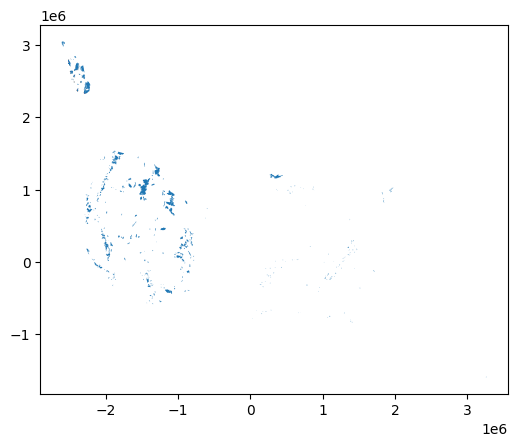

In [19]:
# source directory
data_dir = os.path.join(source_dir, "usfs_wilderness-areas")

# input data
input_file = os.path.join(data_dir, "S_USA.Wilderness.shp")

# read in shapefile
gdf_usfs_wild = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_usfs_wild = gdf_usfs_wild.to_crs(template_crs)

# assign raster value field
gdf_usfs_wild["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_usfs_wilderness_areas_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_usfs_wild, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_usfs_wild.plot()

____________

##### USFS National Designated Areas

> gridcerf_usfs_national_designated_areas_conus.tif

- **Title**: National Forest Lands with Nationally Designated Management or Use Limitations: Legal Status
- **Description from Source**:  A boundary of an area designation within which National Forest System land parcels have management or use limits placed on them by legal authority above the Agency level (e.g. Congress and/or President). Areas that have been designated by Congress, Executive Order, Presidential Proclamation, or an Executive branch Department, excluding National Wilderness and National Wild and Scenic Rivers, with related details including the date of designation, status of the final boundary description, authority, and land status case and document information. Each area designation is characterized by a date, boundary status, and authority and may be just one of several designations that comprise a single national designated area.
- **Source URL**:  https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.OthNatlDesgAreaStatus.zip
- **Date Accessed**:  10/11/2023
- **Citation**
> US Forest Service. National Forest Lands with Nationally Designated Management or Use Limitations: Legal Status. Download National Datasets https://data.fs.usda.gov/geodata/edw/datasets.php?xmlKeyword=wilderness (accessed 10/11/23).


<Axes: >

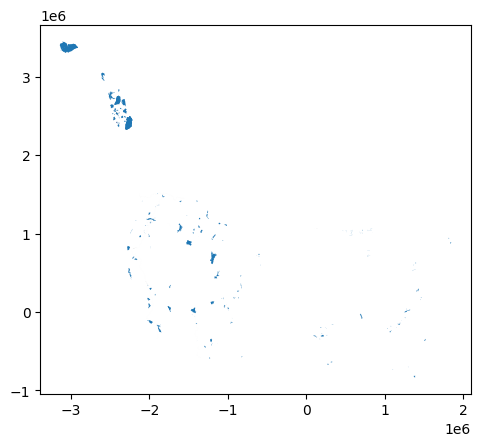

In [20]:
# source directory
data_dir = os.path.join(source_dir, "usfs_nat_designated_areas", "S_USA.OthNatlDesgAreaStatus")

# input data
input_file = os.path.join(data_dir, "S_USA.OthNatlDesgAreaStatus.shp")

# read in shapefile
gdf_nat_deg = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_nat_deg = gdf_nat_deg.to_crs(template_crs)

# assign raster value field
gdf_nat_deg["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_usfs_national_designated_areas_conus")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_nat_deg, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_nat_deg.plot()

_______

#### 3.3.10 World Database of Protected Areas Layers

##### The Nature Conservency Managed Lands

> gridcerf_wdpa_tnc_managed_lands_conus.tif

- **Title**:  The Nature Conservancy (TNC) Lands
- **Description from Source**:  This TNC Lands spatial dataset represents the lands and waters in which The Nature Conservancy (TNC) currently has, or historically had, an interest, legal or otherwise. The system of record for TNC Lands is the Legal Records Management (LRM) system, which is TNC’s database for all TNC land transactions. 
- **Source URL**:  https://geospatial.tnc.org/datasets/TNC::tnc-lands-north-america/about?layer=0
- **Date Accessed**:  7/28/23
- **Citation**
> The Nature Conservancy. The Nature Conservancy lands. The Nature Conservancy (TNC) Lands https://geospatial.tnc.org/datasets/TNC::tnc-lands-north-america/about?layer=0 (2022).


<Axes: >

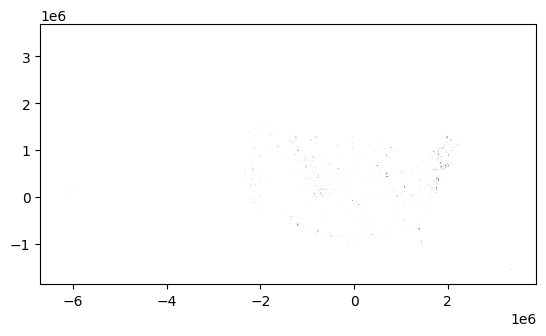

In [21]:
# source directory
data_dir = os.path.join(source_dir, "tnc_lands")

# input data
input_file = os.path.join(data_dir, "TNC_Lands_North_America.shp")

# read in shapefile
gdf_tnc = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf_tnc = gdf_tnc.to_crs(template_crs)

# assign raster value field
gdf_tnc["rval"] = 1

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_wdpa_tnc_managed_lands_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf_tnc, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

gdf_tnc.plot()

_______

#### 3.3.9 US Geological Survey Layers

##### Protected Areas Database Class 1 & 2

>gridcerf_usgs_padus_class_1_to_2_conus.tif

- **Title**:  Protected Areas Database of the United States (PAD-US) 3.0 (ver. 2.0, March 2023)
- **Description from Source**:  The USGS Protected Areas Database of the United States (PAD-US) is the nation's inventory of protected areas, including public land and voluntarily provided private protected areas, identified as an A-16 National Geospatial Data Asset in the Cadastre Theme ( https://ngda-cadastre-geoplatform.hub.arcgis.com/ ). The PAD-US is an ongoing project with several published versions of a spatial database including areas dedicated to the preservation of biological diversity, and other natural (including extraction), recreational, or cultural uses, managed for these purposes through legal or other effective means. The database was originally designed to support biodiversity assessments; however, its scope expanded in recent years to include all open space public and nonprofit lands and waters. Most are public lands owned in fee (the owner of the property has full and irrevocable ownership of the land); however, permanent and long-term easements, leases, agreements, Congressional (e.g. 'Wilderness Area'), Executive (e.g. 'National Monument'), and administrative designations (e.g. 'Area of Critical Environmental Concern') documented in agency management plans are also included. The PAD-US strives to be a complete inventory of U.S. public land and other protected areas, compiling best available data provided by managing agencies and organizations. The PAD-US geodatabase maps and describes areas using thirty-six attributes and five separate feature classes representing the U.S. protected areas network: Fee (ownership parcels), Designation, Easement, Marine, Proclamation and Other Planning Boundaries.  An additional Combined feature class includes the full PAD-US inventory to support data management, queries, web mapping services, and analyses. The Feature Class (FeatClass) field in the Combined layer allows users to extract data types as needed. A Federal Data Reference file geodatabase lookup table (ADUS3_0Combined_Federal_Data_References) facilitates the extraction of authoritative federal data provided or recommended by managing agencies from the Combined PAD-US inventory. This PAD-US Version 3.0 dataset includes a variety of updates from the previous Version 2.1 dataset (USGS, 2020, https://doi.org/10.5066/P92QM3NT ), achieving goals to: 1) Annually update and improve spatial data representing the federal estate for PAD-US applications; 2) Update state and local lands data as state data-steward and PAD-US Team resources allow; and 3) Automate data translation efforts to increase PAD-US update efficiency. The following list summarizes the integration of best available spatial data to ensure public lands and other protected areas from all jurisdictions are represented in the PAD-US (other data were transferred from PAD-US 2.1).  Federal updates - The USGS remains committed to updating federal fee owned lands data and major designation changes in annual PAD-US updates, where authoritative data provided directly by managing agencies are available or alternative data sources are recommended. The following is a list of updates or revisions associated with the federal estate: 1) Major update of the Federal estate (fee ownership parcels, easement interest, and management designations where available), including authoritative data from 8 agencies: Bureau of Land Management (BLM), U.S. Census Bureau (Census Bureau), Department of Defense (DOD), U.S. Fish and Wildlife Service (FWS), National Park Service (NPS), Natural Resources Conservation Service (NRCS), U.S. Forest Service (USFS), and National Oceanic and Atmospheric Administration (NOAA). The federal theme in PAD-US is developed in close collaboration with the Federal Geographic Data Committee (FGDC) Federal Lands Working Group (FLWG, https://ngda-gov-units-geoplatform.hub.arcgis.com/pages/federal-lands-workgroup ). 2) Improved the representation (boundaries and attributes) of the National Park Service, U.S. Forest Service, Bureau of Land Management, and U.S. Fish and Wildlife Service lands, in collaboration with agency data-stewards, in response to feedback from the PAD-US Team and stakeholders. 3) Added a Federal Data Reference file geodatabase lookup table (PADUS3_0Combined_Federal_Data_References) to the PAD-US 3.0 geodatabase to facilitate the extraction (by Data Provider, Dataset Name, and/or Aggregator Source) of authoritative data provided directly (or recommended) by federal managing agencies from the full PAD-US inventory. A summary of the number of records (Frequency) and calculated GIS Acres (vs Documented Acres) associated with features provided by each Aggregator Source is included; however, the number of records may vary from source data as the "State Name" standard is applied to national files. The Feature Class (FeatClass) field in the table and geodatabase describe the data type to highlight overlapping features in the full inventory (e.g. Designation features often overlap Fee features) and to assist users in building queries for applications as needed. 4) Scripted the translation of the Department of Defense, Census Bureau, and Natural Resource Conservation Service source data into the PAD-US format to increase update efficiency. 5) Revised conservation measures (GAP Status Code, IUCN Category) to more accurately represent protected and conserved areas. For example, Fish and Wildlife Service (FWS) Waterfowl Production Area Wetland Easements changed from GAP Status Code 2 to 4 as spatial data currently represents the complete parcel (about 10.54 million acres primarily in North Dakota and South Dakota). Only aliquot parts of these parcels are documented under wetland easement (1.64 million acres). These acreages are provided by the U.S. Fish and Wildlife Service and are referenced in the PAD-US geodatabase Easement feature class 'Comments' field. State updates - The USGS is committed to building capacity in the state data-steward network and the PAD-US Team to increase the frequency of state land updates, as resources allow. The USGS supported efforts to significantly increase state inventory completeness with the integration of local parks data in the PAD-US 2.1, and developed a state-to-PAD-US data translation script during PAD-US 3.0 development to pilot in future updates. Additional efforts are in progress to support the technical and organizational strategies needed to increase the frequency of state updates. The PAD-US 3.0 included major updates to the following three states: 1) California - added or updated state, regional, local, and nonprofit lands data from the California Protected Areas Database (CPAD), managed by GreenInfo Network, and integrated conservation and recreation measure changes following review coordinated by the data-steward with state managing agencies. Developed a data translation Python script (see Process Step 2 Source Data Documentation) in collaboration with the data-steward to increase the accuracy and efficiency of future PAD-US updates from CPAD. 2) Virginia - added or updated state, local, and nonprofit protected areas data (and removed legacy data) from the Virginia Conservation Lands Database, provided by the Virginia Department of Conservation and Recreation's Natural Heritage Program, and integrated conservation and recreation measure changes following review by the data-steward. 3) West Virginia - added or updated state, local, and nonprofit protected areas data provided by the West Virginia University, GIS Technical Center. For more information regarding the PAD-US dataset please visit, https://www.usgs.gov/programs/gap-analysis-project/science/protected-areas. For more information about data aggregation please review the PAD-US Data Manual available at https://www.usgs.gov/programs/gap-analysis-project/pad-us-data-manual. A version history of PAD-US updates is summarized below (See https://www.usgs.gov/programs/gap-analysis-project/pad-us-data-history for more information): 1) First posted - April 2009 (Version 1.0 - available from the PAD-US: Team pad-us@usgs.gov). 2) Revised - May 2010 (Version 1.1 - available from the PAD-US: Team pad-us@usgs.gov). 3) Revised - April 2011 (Version 1.2 - available from the PAD-US: Team pad-us@usgs.gov). 4) Revised - November 2012 (Version 1.3) https://doi.org/10.5066/F79Z92XD 5) Revised - May 2016 (Version 1.4) https://doi.org/10.5066/F7G73BSZ 6) Revised - September 2018 (Version 2.0) https://doi.org/10.5066/P955KPLE 7) Revised - September 2020 (Version 2.1) https://doi.org/10.5066/P92QM3NT 8) Revised - January 2022 (Version 3.0) https://doi.org/10.5066/P9Q9LQ4B Comparing protected area trends between PAD-US versions is not recommended without consultation with USGS as many changes reflect improvements to agency and organization GIS systems, or conservation and recreation measure classification, rather than actual changes in protected area acquisition on the ground.
- **Source URL**:  https://doi.org/10.5066/P9Q9LQ4B
- **Date Accessed**:  7/20/23
- **Citation**
> U.S. Geological Survey Gap Analysis Project. Protected Areas Database of the United States (PAD-US) 3.0 (ver. 2.0, March 2023). ScienceBase-Catalog https://doi.org/10.5066/P9Q9LQ4B (2023).


**NOTE 1**:  GAP status class 1 and 2 are selected for exclusion:
1. managed for biodiversity - disturbance events proceed or are mimicked
2. managed for biodiversity - disturbance events suppressed


Many of the areas included in the PADUS data are already included in the other common layers (e.g., national parks, national monuments). To avoid creating heavily correlated layers and to identify areas more distinctly, the areas in the combined common layers compiled above in this notebook are removed from the PADUS layer. The remaining areas are included in the PADUS raster layer 

#### Create combined common layer

In [48]:
# create a combined common layer of other areas
gdf_list = [gdf_bor, gdf_mil, gdf_nat_mon, gdf_blm_wild, gdf_blm_study, gdf_airsheds, gdf_crit, gdf_spec, gdf_wetlands, gdf_nps,
            gdf_hist_trail, gdf_scenic_trail, gdf_rivers, gdf_usfs_wild, gdf_nat_deg, gdf_tnc]

gdf_common = pd.concat(gdf_list)

gdf_common = gpd.GeoDataFrame(gdf_common, geometry=gdf_common.geometry, crs='ESRI:102003')

gdf_common.geometry = gdf_common.geometry.buffer(0)

gdf_common = gdf_common.reset_index()

gdf_common = gdf_common.dissolve()

<Axes: >

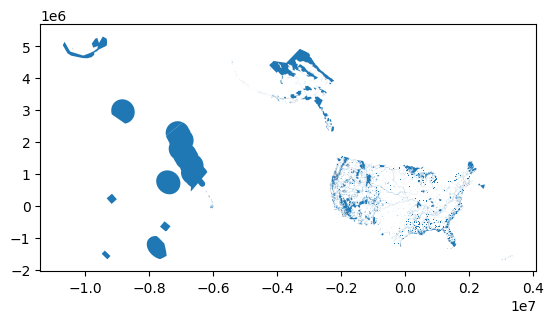

In [49]:
gdf_common.plot()

In [150]:
# output raster name
combined_common_output_raster = os.path.join(tmp_dir, f"gridcerf_combined_non_padus.tif")

# rasterize and save to tmp directory
vector_to_raster(template_raster, 
                 gdf_common, 
                 value_field="rval", 
                 output_raster=combined_common_output_raster,
                 all_touched=True)

#### Create PADUS Class 1 & 2 Layers

<Axes: >

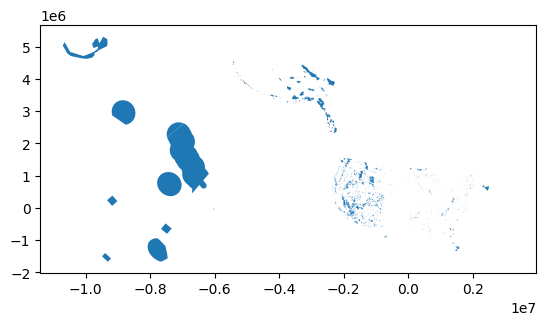

In [50]:
# source directory
data_dir = os.path.join(source_dir, "usgs_padus-3.0")

# input data
input_file = os.path.join(data_dir, "PADUS3_0Geodatabase/PAD_US3_0.gdb")

# read in shapefile
gdf_padus = gpd.read_file(input_file, driver='FileGDB', layer='PADUS3_0Designation')

# extract GAP status 1 and 2 pologons
gdf_padus = gdf_padus.loc[gdf_padus["GAP_Sts"].isin(["1", "2"])]

# reproject to GRIDCERF 
gdf_padus = gdf_padus.to_crs(template_crs)

# assign raster value field
gdf_padus["rval"] = 1

gdf_padus.geometry = gdf_padus.geometry.buffer(0)

gdf_padus = gdf_padus.dissolve()

gdf_padus.plot()

In [149]:
# output raster name
output_raster = os.path.join(tmp_dir, f"gridcerf_usgs_padus_class_1_to_2_conus.tif")

# rasterize and save to tmp directory 
vector_to_raster(template_raster, 
                 gdf_padus, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)

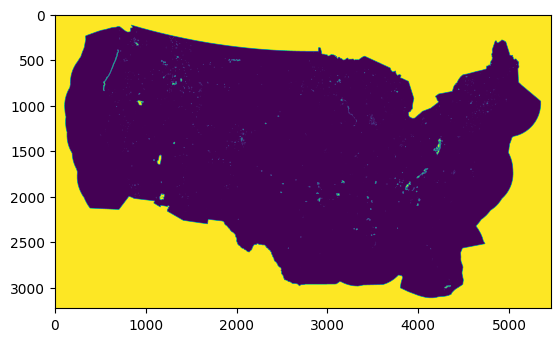

In [151]:
# read in tmp padus tif
padus_raster = rasterio.open(output_raster)
burned = padus_raster.read(1)

# read in tmp combined common tif
common_raster = rasterio.open(combined_common_output_raster)
common = common_raster.read(1)

# adjust binary values for combined common
common = np.where(common==1, 10, 5)

combined = common + burned

output_raster = os.path.join(output_dir, f"gridcerf_usgs_padus_class_1_to_2_conus_additions.tif")

with rasterio.open(template_raster) as template:

    metadata = template.meta.copy()

    # update raster data type
    metadata.update(dtype=np.int16)

    # extract land mask
    land_mask = template.read(1)
    land_mask = np.where(land_mask == 0, np.nan, 1)

    final = np.where(combined != 6 , 0, 1).astype(np.float64)
    final *= land_mask
    final = np.where(np.isnan(final), 1, final)
    show(final)

    with rasterio.open(output_raster, 'w+', **metadata) as out:
    
        out_arr = out.read(1)
            
        out.write_band(1, final.astype(np.int16))